In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ahmednabiled_teeth_dataset_path = kagglehub.dataset_download('ahmednabiled/teeth-dataset')

print('Data source import complete.')


Data source import complete.


In [2]:
!pip install torch torchvision torchaudio --upgrade
!pip install tqdm matplotlib seaborn pandas torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201

In [3]:
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import time
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

batch_size = 16

data_dir = "/kaggle/input/teeth-dataset/Teeth_Dataset/"
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "Training"), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "Validation"), transform=test_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "Testing"), transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_classes = len(train_dataset.classes)

train_data_size = len(train_dataset)
valid_data_size = len(val_dataset)
test_data_size = len(test_dataset)

In [5]:
resnet50 = models.resnet50(weights = 'DEFAULT')
resnet50 = resnet50.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 144MB/s]


In [6]:
for param in resnet50.parameters():
    param.requires_grads = False

In [7]:
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes),
    nn.LogSoftmax(dim=1)
)

In [8]:
loss_func = nn.NLLLoss()
learning_rate = 0.01
optimizer = optim.SGD(
    params=resnet50.parameters(),
    lr=learning_rate,
    momentum=0.9
)

In [9]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        model.train()

        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            train_acc += acc.item() * inputs.size(0)

        with torch.no_grad():
            model.eval()
            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = loss_criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * inputs.size(0)

        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

            torch.save(model, 'best_model.pt')

        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_acc = valid_acc/valid_data_size
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
        epoch_end = time.time()
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

    return model, history, best_epoch

In [10]:
print(summary(resnet50, input_size=(batch_size, 3, 256, 256)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 7]                   --
├─Conv2d: 1-1                            [16, 64, 128, 128]        9,408
├─BatchNorm2d: 1-2                       [16, 64, 128, 128]        128
├─ReLU: 1-3                              [16, 64, 128, 128]        --
├─MaxPool2d: 1-4                         [16, 64, 64, 64]          --
├─Sequential: 1-5                        [16, 256, 64, 64]         --
│    └─Bottleneck: 2-1                   [16, 256, 64, 64]         --
│    │    └─Conv2d: 3-1                  [16, 64, 64, 64]          4,096
│    │    └─BatchNorm2d: 3-2             [16, 64, 64, 64]          128
│    │    └─ReLU: 3-3                    [16, 64, 64, 64]          --
│    │    └─Conv2d: 3-4                  [16, 64, 64, 64]          36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 64, 64]          128
│    │    └─ReLU: 3-6                    [16, 64, 64, 64]          --
│ 

In [11]:
num_epochs = 15
trained_model, history, best_epoch = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

Epoch: 1/15
Epoch : 000, Training: Loss - 1.3551, Accuracy - 49.5951%, 
		Validation : Loss - 0.8306, Accuracy - 71.4981%, Time: 73.6753s
Epoch: 2/15
Epoch : 001, Training: Loss - 0.6159, Accuracy - 79.2355%, 
		Validation : Loss - 0.3656, Accuracy - 87.1595%, Time: 58.3348s
Epoch: 3/15
Epoch : 002, Training: Loss - 0.3527, Accuracy - 88.4354%, 
		Validation : Loss - 0.2533, Accuracy - 90.9533%, Time: 56.9090s
Epoch: 4/15
Epoch : 003, Training: Loss - 0.2116, Accuracy - 92.8733%, 
		Validation : Loss - 0.0777, Accuracy - 97.4708%, Time: 58.8062s
Epoch: 5/15
Epoch : 004, Training: Loss - 0.1546, Accuracy - 94.8818%, 
		Validation : Loss - 0.0502, Accuracy - 98.6381%, Time: 56.7541s
Epoch: 6/15
Epoch : 005, Training: Loss - 0.0949, Accuracy - 96.8254%, 
		Validation : Loss - 0.0977, Accuracy - 96.5953%, Time: 56.2239s
Epoch: 7/15
Epoch : 006, Training: Loss - 0.0826, Accuracy - 97.2141%, 
		Validation : Loss - 0.2027, Accuracy - 96.6926%, Time: 58.0509s
Epoch: 8/15
Epoch : 007, Training:

In [12]:
dataset = 'teeth'
torch.save(history, dataset+'_history.pt')

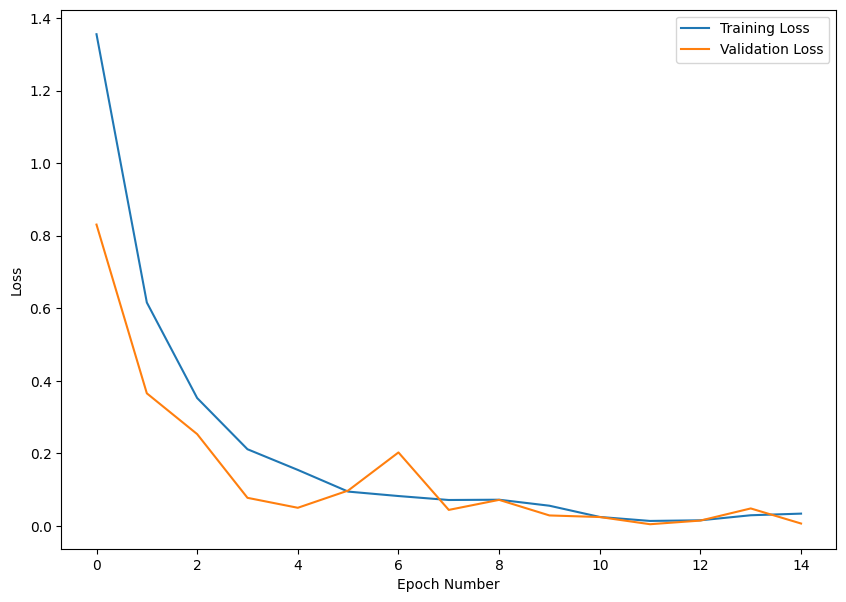

In [13]:
plt.figure(figsize=(10, 7))
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.savefig('loss_curve.png')
plt.show()

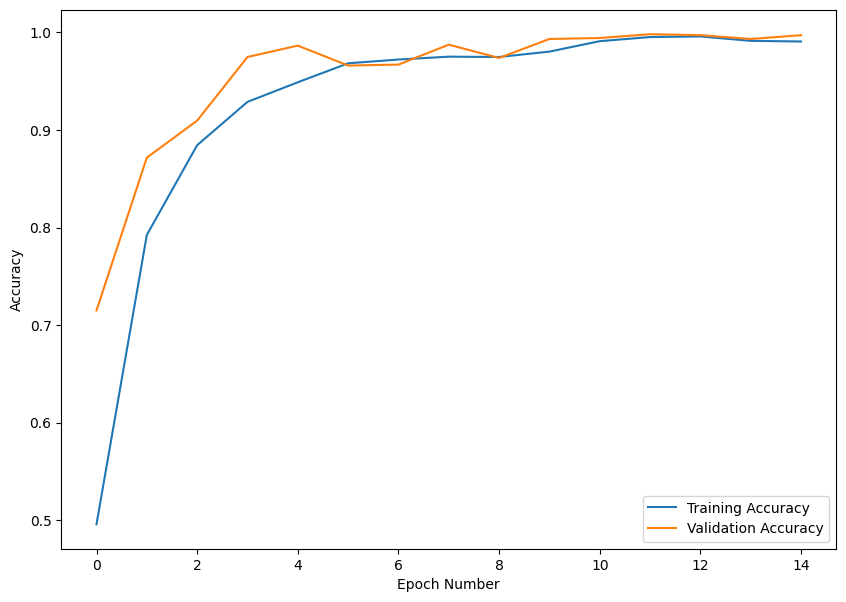

In [14]:
plt.figure(figsize=(10, 7))
plt.plot(history[:,2:4])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.savefig('accuracy_curve.png')
plt.show()

In [15]:
def computeTestSetAccuracy(model, loss_criterion):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0


    with torch.no_grad():

        model.eval()

        for j, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            loss = loss_criterion(outputs, labels)


            test_loss += loss.item() * inputs.size(0)


            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))


            acc = torch.mean(correct_counts.type(torch.FloatTensor))


            test_acc += acc.item() * inputs.size(0)

            print(f"Test Batch number: {j:03d}, Test: Loss: {loss.item():.4f}, Accuracy: {acc.item():.4f}")


    avg_test_loss = test_loss / test_data_size
    avg_test_acc = test_acc / test_data_size

    print("Test accuracy: {:.4f}".format(avg_test_acc))

In [17]:
!pip install streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 128.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 9.1 MB/s eta 0:00:00


In [28]:
%%writefile app.py
import streamlit as st
from PIL import Image
import torch
import torchvision.transforms as transforms

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


@st.cache_resource
def load_model():
    model = torch.load("best_model.pt", weights_only=False)
    model.eval()
    return model

st.title("🦷 Teeth Classification Demo")


try:
    model = load_model()
except FileNotFoundError:
    st.error("Model file not found. Please make sure 'best_model.pt' is in the same directory as app.py.")
    st.stop()


uploaded_file = st.file_uploader("Upload a dental photo", type=["png", "jpg", "jpeg"])

if uploaded_file:
    img = Image.open(uploaded_file).convert("RGB")
    st.image(img, caption="Input image", use_column_width=True)


    x = test_transform(img).unsqueeze(0)


    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)
        conf, idx = probs.max(1)


    classes = train_dataset.classes

    pred_class = classes[idx.item()]

    # Display the result
    st.markdown(f"### **Prediction:** `{pred_class}`")
    st.markdown(f"#### **Confidence:** `{conf.item():.2%}`")

Overwriting app.py


In [19]:
! ngrok config add-authtoken 2zjvL14xVSsKo5AMzw1uZMfTYgK_o8L2ieHSBdvorB4bHQPs

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok

public_url = ngrok.connect(8501)
print(" * ngrok tunnel:", public_url)

# 2) launch Streamlit in the background
!streamlit run app.py &

 * ngrok tunnel: NgrokTunnel: "https://aa94b8cfdc5b.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.87.106.183:8501

2025-07-11 19:56:08.166 The `use_column_width` parameter has been deprecated and will be removed in a future release. Please utilize the `use_container_width` parameter instead.
────────────────────────── Traceback (most recent call last) ───────────────────────────
  /usr/local/lib/python3.11/dist-packages/streamlit/runtime/scriptrunner/exec_code.py:  
  128 in exec_func_with_error_handling                                                  
                                                                                        
  /usr/local/lib/python3.11/dist-packages/streamlit/runtime/scriptrunner/script_runner  
  .py:669 in code_to_exec                                                               
                 